In [5]:
import pandas as pd
train = pd.read_feather('Feathers/processed_train_data.feather')
train.head()

,text,label
0,reader mail sc ruling alimony supreme court ex...,0
1,niqaab elephant courtroom say uk judge person ...,0
2,grandparent honoured staff student global publ...,0
3,guardian quick crossword convinced know pay news,0
4,fisherman call strike country boat fisherman p...,1


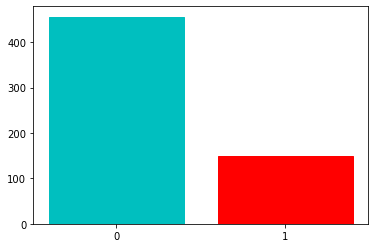

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# get label counts
labels = data.label.unique()
counts = data.label.value_counts()
y_pos = np.arange(len(labels))
 
# create bars
bars = plt.bar(y_pos, counts)
bars[0].set_color('c')
bars[1].set_color('r')
 
# create names on the x-axis
plt.xticks(y_pos, labels)

# show graph
plt.show()

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

parameters = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__min_df': (0.01, 0.05, 0.1, 1.0),
    'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3)),  # unigrams, bigrams or trigrams
    'tfidf__use_idf': (True, False),
    'tfidf__smooth_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0),
    'clf__fit_prior': (True, False),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
grid_search.fit(train.text, train.label)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 4032 candidates, totalling 20160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best score: 0.871
Best parameters set:
	clf__alpha: 0.1
	clf__fit_prior: True
	tfidf__max_df: 0.75
	tfidf__min_df: 0.01
	tfidf__ngram_range: (1, 1)
	tfidf__norm: 'l2'
	tfidf__smooth_idf: True
	tfidf__use_idf: False


In [8]:
test = pd.read_feather('Feathers/processed_test_data.feather')
test.head()

,text,label
0,ranipet student top vellore district special c...,0
1,science camp schoolchildren science camp merit...,0
2,bahutule retires five day th birthday vidarbha...,0
3,heavy rain likely next three day woman reporte...,0
4,police complaint caste hindu dalit resident pa...,0


              precision    recall  f1-score   support

           0       0.98      0.97      0.97       456
           1       0.90      0.93      0.91       150

    accuracy                           0.96       606
   macro avg       0.94      0.95      0.94       606
weighted avg       0.96      0.96      0.96       606



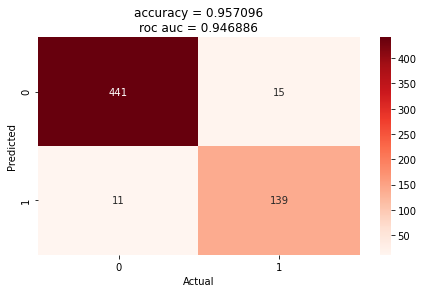

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import seaborn as sns

y_pred = grid_search.predict(train.text)
print(classification_report(train.label, y_pred))

conf_matrix = confusion_matrix(train.label, y_pred)
plt.figure(figsize=(7.2,4))
sns.heatmap(conf_matrix, 
            annot=True,
            fmt='g',
            xticklabels=[0, 1], 
            yticklabels=[0, 1],
            cmap="Reds",)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('accuracy = %f\nroc auc = %f' %(accuracy_score(train.label, y_pred), roc_auc_score(train.label, y_pred)))
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       153
           1       0.84      0.76      0.80        50

    accuracy                           0.91       203
   macro avg       0.88      0.86      0.87       203
weighted avg       0.90      0.91      0.90       203



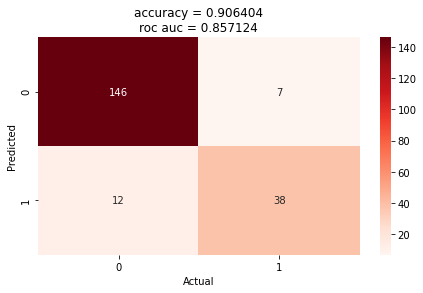

In [14]:
y_pred = grid_search.predict(test.text)
print(classification_report(test.label, y_pred))
conf_matrix = confusion_matrix(test.label, y_pred)
plt.figure(figsize=(7.2,4))
sns.heatmap(conf_matrix, 
            annot=True,
            fmt='g',
            xticklabels=[0, 1], 
            yticklabels=[0, 1],
            cmap="Reds",)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('accuracy = %f\nroc auc = %f' %(accuracy_score(test.label, y_pred), roc_auc_score(test.label, y_pred)))
plt.show()

In [16]:
d = {
    'Model': 'Multinomial Naïve Bayes',
    'Training Set Accuracy': accuracy_score(train.label, grid_search.predict(train.text)),
    'Training Set ROC AUC': roc_auc_score(train.label, grid_search.predict(train.text)),
    'Test Set Accuracy': accuracy_score(test.label, y_pred),
    'Test Set ROC AUC': roc_auc_score(test.label, y_pred),
}

df_models_mnb = pd.DataFrame(d, index=[0])
df_models_mnb

,Model,Training Set Accuracy,Training Set ROC AUC,Test Set Accuracy,Test Set ROC AUC
0,Multinomial Naïve Bayes,0.957096,0.946886,0.906404,0.857124


In [17]:
df_models_mnb.to_feather('Feathers/Models/mnb.feather')